In [1]:
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import Phrases
from gensim.models import CoherenceModel

import spacy
import en_core_web_lg

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

from pprint import pprint
import warnings
warnings.filterwarnings("ignore")

# 1. Data Source

<img align='center' src="images/Image 157.png">

##### Compliance
1. **Compliance-related websites**: SEC, FCPA, NYSE, WSJ RISK & COMPLIANCE JOURNAL, Corportate Compliance Insights, Financial Services Perspectives

##### Non-compliance
<!-- list-start: 3 -->
2. **Other Websites**: CNBC, financial times, ESPN SPORT, Fortune, Fox Sport, The Boston Globe, The Auto Blog

In [8]:
# Import three data sources and give them labels
# Not compliance articles
compliance = pd.read_csv('Compliance_data_1029.csv')
compliance['text'] = np.nan
compliance.loc[(~compliance.Summary.isna()), 'text'] = compliance['Headline']+ '. ' + compliance['Summary']
compliance.loc[(~compliance.Paragrah.isna()) & (compliance.Summary.isna()), 'text'] = compliance['Headline']
compliance.loc[(compliance.Summary.isna()), 'text'] = compliance['Headline']
compliance['class'] = 'compliance'

compliance = compliance.loc[compliance.Website != 'SEC']
sec_new = pd.read_csv('SEC_300_1102.csv')
sec_new['Paragrah'] = np.nan
sec_new['Image URL'] = np.nan
sec_new['text'] = sec_new['title']+ '. ' + sec_new['summary']
sec_new['class'] = 'compliance'

sec_new.columns = ['Website', 'Timestamp', 'Link', 'Headline', 'Summary', 'Paragrah', 'Image URL', 'text', 'class']
sec_new = sec_new.loc[:, list(compliance.columns)]

compliance = pd.concat([compliance, sec_new], ignore_index=True)


non_compliance = pd.read_csv('Non-Compliance_data_1029.csv').dropna()
cols = ['class', 'text', 'Website']
news_df = pd.concat([compliance[cols], non_compliance[cols]], ignore_index=True)
news_df.head()

,class,text,Website
0,compliance,World Bank debars unit of state-owned China co...,FCPA
1,compliance,What to do in a crisis? Shake off the crisis m...,FCPA
2,compliance,DOJ fines ‘uncooperative’ Beam Suntory $19.6 m...,FCPA
3,compliance,Former UK prosecutor: Four things investigator...,FCPA
4,compliance,Wall Street bank earns top spot on FCPA Blog t...,FCPA


### Preproces texts

In [9]:
stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in papers:
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
    return norm_papers

tokenized_docs = normalize_corpus(compliance.loc[compliance.Website != 'NYSE', 'text'])
print(len(tokenized_docs))

1498


# 2. Topic Modeling

<img src="images/Image 158.png">

### Create Bigram Corpus

In [10]:
bigram = Phrases(tokenized_docs, min_count=10, threshold=10)
bigram_texts = [bigram[line] for line in tokenized_docs]

id2word = Dictionary(bigram_texts)
print('Total Vocabulary Size (Before):', len(id2word))
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=15, no_above=0.6)
print('Total Vocabulary Size (After):', len(id2word))

corpus = [id2word.doc2bow(line) for line in bigram_texts]

Total Vocabulary Size (Before): 10601
Total Vocabulary Size (After): 1521


### Build LDA Model

**Choose the number of topics -  Topic Coherence**

Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.

reference: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [11]:
def compute_coherence_values(corpus, id2word, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=len(bigram_texts),
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=bigram_texts, 
                                         dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

cv_scores = []

for k in range(2,20):
    score = compute_coherence_values(corpus=corpus, id2word=id2word, k=k)
    cv_scores.append(score)
    print(k, score)

2 0.24459873132629056
3 0.4168603539134848
4 0.4102308673512176
5 0.40159714074654856
6 0.4022589656942383
7 0.45519540425877164
8 0.43396878757117363
9 0.36765904393084714
10 0.3260398570216034
11 0.4772807655493901
12 0.44975057125615975
13 0.42876516702497575
14 0.5754694492000241
15 0.538219633010199
16 0.5809348873840546
17 0.4870693944725599
18 0.497539998798074
19 0.563777308218867


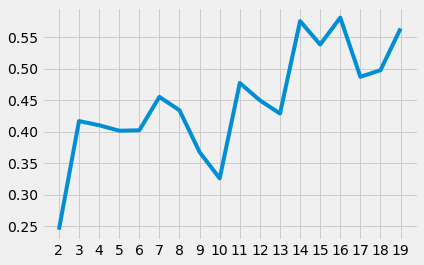

In [14]:
optimal_k = np.array(cv_scores).argmax() + 2
plt.style.use('fivethirtyeight')
#plt.figure(facecolor='white')
#mpl.rcParams['axes.facecolor'] = 'white'
sns.lineplot(x=np.arange(2, 20), y=cv_scores)
plt.xticks(np.arange(2,20))
plt.show()

### Set the number of topics as 14 and Build the LDA model again 

In [15]:
from gensim.models import LdaModel, LdaMulticore
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         random_state=100,
                         num_topics=optimal_k,
                         passes=10,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)

#pprint(lda_model.print_topics())

In [230]:
# save model
#pickle.dump(lda_model, open('LDA_1102_14topics','wb')) # 14 topics
#lda_model = pickle.load(open('LDA_110', 'rb'))

### Visaulize Topic Modeling Results

In [22]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.107124 -0.019844       1        1  17.692992
3     -0.131341  0.115448       2        1  16.768808
11    -0.103150 -0.066900       3        1  16.645308
4     -0.123652  0.053100       4        1  13.075096
12    -0.104060 -0.035864       5        1   9.043396
2      0.024265 -0.152476       6        1   8.100337
1      0.090069  0.238632       7        1   3.575543
13    -0.055177 -0.037016       8        1   3.383962
9      0.083683 -0.040297       9        1   2.508477
7      0.076976 -0.022057      10        1   2.444999
14     0.172127 -0.004843      11        1   1.866821
5      0.075169 -0.027224      12        1   1.772840
8      0.067093 -0.050475      13        1   1.598831
6     -0.008340  0.016673      14        1   0.964075
10     0.001150  0.019251      15        1   0.458158
15     0.042311  0.013891      16        1   0.100356, topic_info=           Term         Freq        Total Category  logprob  loglift
174  compliance  1173.000000  1173.000000  Default  30.0000  30.0000
77         risk   968.000000   968.000000  Default  29.0000  29.0000
160        data   528.000000   528.000000  Default  28.0000  28.0000
79          sec   593.000000   593.000000  Default  27.0000  27.0000
586       board   174.000000   174.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
652       issue     0.131360   130.040793  Topic16  -6.3506   0.0065
174  compliance     0.148206  1173.769186  Topic16  -6.2300  -2.0729
266      market     0.128670   220.198765  Topic16  -6.3713  -0.5408
77         risk     0.135723   968.648488  Topic16  -6.3179  -1.9688
401  technology     0.126531   285.409120  Topic16  -6.3881  -0.8170

[852 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
1334      1  0.044057     according_chosen
1334      3  0.044057     according_chosen
1334      8  0.044057     according_chosen
1334     11  0.748971     according_chosen
997       2  0.770086  according_complaint
...     ...       ...                  ...
309       6  0.049520                  yet
309       7  0.024760                  yet
309       8  0.074280                  yet
309      10  0.024760                  yet
309      14  0.024760                  yet

[4390 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 12, 5, 13, 3, 2, 14, 10, 8, 15, 6, 9, 7, 11, 16])

* The area of circle represents the importance of each topic over the entire corpus
* The distance between the center of circles indicate the similarity between topics. 
* For each topic, the histogram on the right side listed the top 30 most relevant terms.

<br></br>
# 3. Select Keywords

<img src="images/Image 159.png">

### select top 20 words from each group as our keywords and filter out repeated words and words without critical meanings

In [23]:
removing_list = ['may', 'said', 'case_ey', 'deloitte', 'ey_america', 'say', 'also', 'three_percent', 'list', 'report', 'one', 'two', 'many', 'use', 'percent', 'today', 'three', 'two']

In [24]:
x=lda_model.show_topics(num_words=20, num_topics=optimal_k, formatted=False)

twords={}

for topic, word in x:
    twords[topic] = list(tuple(zip(*word))[0])
    
features = []

for words in twords.values():
    features.extend(words)

feature_dict = {}
    
for i, word in enumerate(set(features)):
    if (word not in feature_dict.keys()):
        feature_dict[word] = len(feature_dict)

print('The Number of Total Keywords: {}'.format(len(feature_dict)))

The Number of Total Keywords: 232


<br></br>
# 4. Build Text Classification Model

<img src="images/Image 160.png">

In [25]:
def featurize(texts, bigram_phrase, feature_dict):
    tokenized_docs = normalize_corpus(texts)
    bigram_texts = [bigram_phrase[line] for line in tokenized_docs]

    data = np.zeros((len(texts), len(feature_dict)))

    for i, text in enumerate(bigram_texts):
        for word in text:
            if word in feature_dict.keys():
                word_idx = feature_dict[word]
                data[i, word_idx] += 1
    
    return data

In [26]:
# Add non-compliance documents 
data = featurize(news_df['text'], bigram, feature_dict)

X = data
Y = news_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=122)

pipeline = Pipeline([('clf', RandomForestClassifier())]) # Use Random Forest to identify topic 
model = pipeline.fit(X_train, y_train)

# 5. How well the model can identify compliance articles from a bunch of articles?

In [27]:
ytest = np.array(y_test)
print(classification_report(ytest, model.predict(X_test)))

                precision    recall  f1-score   support

    compliance       0.98      0.88      0.93       324
non-compliance       0.85      0.97      0.91       232

      accuracy                           0.92       556
     macro avg       0.91      0.92      0.92       556
  weighted avg       0.92      0.92      0.92       556



The link about chi-test feature selection:
https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223

# Model Application Example - SEC

In [34]:
sec = pd.read_csv('SEC_10.17.2020.csv')
sec['text'] = sec['headline'] + '. ' + sec['abstract']
sec['category_pred'] = model.predict(featurize(sec['text'], bigram, feature_dict))
prob = pd.DataFrame(model.predict_proba(featurize(sec['text'], bigram, feature_dict)), columns=model.steps[0][1].classes_).round(2)
sec['compliance_probability'] = prob['compliance']

nlp = en_core_web_lg.load()
keywords = nlp(' '.join(features))
all_news_list_token = [[token.lemma_.lower() for token in nlp(news) if token.pos_ in ['NOUN', 'PROPN']] for news in sec.text]
sec['similarity_score'] = [nlp(' '.join(news)).similarity(keywords) for news in all_news_list_token]

In [36]:
sec[['headline', 'category_pred', 'compliance_probability', 'similarity_score']]

,headline,category_pred,compliance_probability,similarity_score
0,SEC Updates Auditor Independence Rules,compliance,0.92,0.838145
1,SEC Releases Agenda for October 26 Roundtable ...,compliance,0.90,0.823247
2,SEC and CFTC to Hold a Joint Open Meeting on O...,compliance,0.89,0.706024
3,SEC Charges Andeavor for Inadequate Controls A...,compliance,0.91,0.821219
4,Board Member James G. Kaiser to Retire From th...,compliance,0.87,0.797364
5,SEC Appoints PCAOB Chief Auditor Megan Zietsma...,compliance,0.94,0.823922
6,"SEC Awards $800,000 to Whistleblower",compliance,0.91,0.789850
7,SEC Charges Brazilian Meat Producers With FCPA...,compliance,0.92,0.761724
8,Tamara Brightwell Named Deputy Director of Div...,compliance,0.85,0.782475
9,Jessica Kane Named Director of Division of Cor...,compliance,0.89,0.826010


# Model Application Example - Financial Times Regulation Articles

In [40]:
ft_compliance = pd.read_csv('finanical_times_regulation_1028.csv')

ft_compliance['text'] = 'text'
ft_compliance.loc[(~ft_compliance.summary.isna()), 'text'] = ft_compliance['title']+ '. ' + ft_compliance['summary']
ft_compliance.loc[(ft_compliance.summary.isna()), 'text'] = ft_compliance['title']
ft_compliance['category_pred'] = model.predict(featurize(ft_compliance['text'], bigram, feature_dict))
prob = pd.DataFrame(model.predict_proba(featurize(ft_compliance['text'], bigram, feature_dict)), columns=model.steps[0][1].classes_).round(2)
ft_compliance['compliance_prob'] = prob['compliance']

nlp = en_core_web_lg.load()
keywords = nlp(' '.join(features))
all_news_list_token = [[token.lemma_.lower() for token in nlp(news) if token.pos_ in ['NOUN', 'PROPN']] for news in ft_compliance.text]
ft_compliance['similarity_score'] = [nlp(' '.join(news)).similarity(keywords) for news in all_news_list_token]

#ft_compliance[['tag', 'title', 'category_pred', 'compliance_prob', 'similarity_score']]

def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['color: %s' % 'red' if is_max.any() else '' for v in is_max]


In [41]:
(ft_compliance[['tag', 'title', 'category_pred', 'compliance_prob', 'similarity_score']]
 .style.apply(highlight_greaterthan, threshold=.5, column=['compliance_prob'], axis=1)
 .set_table_attributes('style="font-size: 15px"'))

,tag,title,category_pred,compliance_prob,similarity_score
0,US financial regulation,US SEC opens door to more leveraged ETFs,compliance,0.770000,0.774971
1,EU financial regulation,Stock exchanges prepare to activate their Brexit contingency plans,non-compliance,0.430000,0.735572
2,EU financial regulation,EU takes step to ease jitters over dual listings after Brexit,non-compliance,0.000000,0.689356
3,EU financial regulation,Stock exchanges prepare to activate their Brexit contingency plans,non-compliance,0.430000,0.735572
4,EU financial regulation,Stock exchanges prepare to activate their Brexit contingency plans,non-compliance,0.430000,0.735572
5,EU financial regulation,EU explores tougher curbs on City hedge fund managers,non-compliance,0.380000,0.824402
6,EU financial regulation,Stock exchanges prepare to activate their Brexit contingency plans,non-compliance,0.430000,0.735572
7,EU financial regulation,Stock exchanges prepare to activate their Brexit contingency plans,non-compliance,0.430000,0.735572
8,EU financial regulation,Stock exchanges prepare to activate their Brexit contingency plans,non-compliance,0.430000,0.735572
9,US financial regulation,US SEC opens door to more leveraged ETFs,compliance,0.770000,0.774971
